In [70]:
!pip -q install scikit-learn

import re
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import (
    pad_sequence,
    pack_padded_sequence,
    pad_packed_sequence
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import matplotlib.pyplot as plt

# Skip Google Colab mount for local development
# from google.colab import drive
# drive.mount('/content/drive')


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
# Load real Tweets dataset
import json

# Load the actual Tweets.csv dataset
data_path = 'rnn_intent/data/Tweets.csv'
df = pd.read_csv(data_path)
print(f"✓ Loaded real dataset from: {data_path}")
print(f"  Dataset shape: {df.shape}")
print(f"  Columns: {list(df.columns[:5])}...")

# Create sentiment label mapping from the data
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
print(f"✓ Sentiment labels: {label2id}")

# Display sample
display(df[['text', 'airline_sentiment']].head(10))
print(f"\nDataset Info:")
print(f"  Total samples: {len(df)}")
print(f"  Sentiment distribution:\n{df['airline_sentiment'].value_counts()}")

✓ Loaded real dataset from: rnn_intent/data/Tweets.csv
  Dataset shape: (14640, 15)
  Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence']...
✓ Sentiment labels: {'negative': 0, 'neutral': 1, 'positive': 2}


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive



Dataset Info:
  Total samples: 14640
  Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [72]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)      # remove URLs
    s = re.sub(r"@\w+", " ", s)                 # remove @mentions
    s = s.replace("&amp;", " and ")
    s = s.replace("#", " ")                     # keep hashtag word, drop '#'
    s = re.sub(r"[^a-z0-9\s']", " ", s)         # remove punctuation except apostrophe
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(s: str):
    return clean_text(s).split()

In [73]:
# Determine which column contains the labels
if 'airline_sentiment' in df.columns:
    sentiment_col = 'airline_sentiment'
elif 'emotion' in df.columns:
    sentiment_col = 'emotion'
else:
    # Use the last column if neither sentiment column exists
    sentiment_col = df.columns[-1]

# Map labels to IDs
df["label"] = df[sentiment_col].map(label2id)
df = df.dropna(subset=["label"]).copy()
df["label"] = df["label"].astype(int)

# Use the text column (typically 'text', 'Tweet', or similar)
text_col = 'text' if 'text' in df.columns else (df.columns[1] if len(df.columns) > 1 else df.columns[0])
X = df[text_col].values.astype(str)  # Convert to list to avoid pandas arrow issues
y = df["label"].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    list(X), list(y),
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train label counts:", np.bincount(y_train))
print("Test label counts :", np.bincount(y_test))
print(f"Labels mapping: {id2label}")

Train size: 11712 Test size: 2928
Train label counts: [7343 2479 1890]
Test label counts : [1835  620  473]
Labels mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [74]:
PAD, UNK = "<PAD>", "<UNK>"
word2idx = {PAD: 0, UNK: 1}

counter = Counter()
for t in X_train:
    counter.update(tokenize(t))

MAX_VOCAB = 20000
for w, _ in counter.most_common(MAX_VOCAB - len(word2idx)):
    word2idx[w] = len(word2idx)

vocab_size = len(word2idx)
print("vocab_size:", vocab_size)

vocab_size: 11845


In [75]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx])
        ids = [word2idx.get(w, word2idx[UNK]) for w in tokens]
        x = torch.tensor(ids, dtype=torch.long)      # (T,)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

train_ds = TweetDataset(X_train, y_train)
test_ds  = TweetDataset(X_test, y_test)

In [76]:
def pad_and_pack(batch):
    xs, ys, lengths = [], [], []
    for x, y in batch:
        xs.append(x)
        ys.append(y)
        lengths.append(x.shape[0])

    lengths = torch.tensor(lengths, dtype=torch.long)
    ys = torch.stack(ys)

    # pad to (Tmax, B)
    x_padded = pad_sequence(xs, batch_first=False, padding_value=word2idx[PAD])

    # pack (unsorted OK)
    x_packed = pack_padded_sequence(
        x_padded, lengths.cpu(), batch_first=False, enforce_sorted=False
    )
    return x_packed, ys, lengths

In [77]:
BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, collate_fn=pad_and_pack)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, collate_fn=pad_and_pack)

In [78]:
class EmbeddingPackable(nn.Module):
    def __init__(self, embd_layer: nn.Embedding):
        super().__init__()
        self.embd_layer = embd_layer

    def forward(self, x):
        if isinstance(x, torch.nn.utils.rnn.PackedSequence):
            seqs, lengths = pad_packed_sequence(x, batch_first=True)
            seqs = self.embd_layer(seqs.to(x.data.device))
            return pack_padded_sequence(
                seqs, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
        else:
            return self.embd_layer(x)


In [79]:
class BiLSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2,
                 num_classes=3, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = EmbeddingPackable(nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx))
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x_packed):
        x_emb = self.embedding(x_packed)
        _, (h_n, _) = self.lstm(x_emb)

        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h = torch.cat([h_forward, h_backward], dim=1)

        h = self.dropout(h)
        logits = self.fc(h)
        return logits

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# REGULARIZED MODEL to reduce overfitting:
# - Increased dropout: 0.41 -> 0.65 (stronger regularization)
# - Reduced model size: 3 layers -> 2 layers, hidden_dim 178 -> 128
# - Added L2 regularization: weight_decay 1e-2 -> 0.05
# - Early stopping: patience=3 to stop when validation stops improving
model = BiLSTMSentiment(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=128,        # Reduced from 178
    num_layers=2,          # Reduced from 3
    dropout=0.65,          # Increased from 0.55 -> 0.65
    num_classes=3,
    pad_idx=word2idx[PAD]
).to(device)

# class-weighted loss
class_counts = np.bincount(y_train, minlength=3)
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# Stronger L2 regularization: weight_decay increased from 1e-2 to 0.05
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

print("Class counts:", class_counts)
print("Class weights:", class_weights.detach().cpu().numpy())
print("✓ Dropout: 0.65 (increased from 0.55 -> 0.65)")
print("✓ Dropout: 0.55 (higher than 0.41)")
print("✓ Model Size: 2 layers, 128 hidden (reduced from 3 layers, 178 hidden)")

print("✓ Early Stopping: patience=3 epochs")print("✓ L2 Regularization: weight_decay=0.05 (increased from 0.01)")

SyntaxError: invalid syntax (1755459798.py, line 34)

In [81]:
def run_epoch(model, loader, train=True, clip_norm=1.0):
    model.train() if train else model.eval()

    total_loss = 0.0
    all_preds, all_y = [], []

    for x_packed, y, lengths in loader:
        y = y.to(device)
        x_packed = x_packed.to(device)

        if train:
            opt.zero_grad()

        logits = model(x_packed)
        loss = loss_fn(logits, y)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
            opt.step()

        total_loss += loss.item() * y.size(0)

        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_y.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_y = np.concatenate(all_y)

    avg_loss = total_loss / len(all_y)
    acc = (all_preds == all_y).mean()

    # "regular" F1 for imbalanced multiclass: weighted F1
    f1 = f1_score(all_y, all_preds, average="weighted")

    return avg_loss, acc, f1, all_y, all_preds

@torch.no_grad()
def run_epoch_eval_only(model, loader):
    model.eval()
    total_loss = 0.0
    all_preds, all_y = [], []

    for x_packed, y, lengths in loader:
        y = y.to(device)
        x_packed = x_packed.to(device)

        logits = model(x_packed)
        loss = loss_fn(logits, y)

        total_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_y.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_y = np.concatenate(all_y)

    avg_loss = total_loss / len(all_y)
    acc = (all_preds == all_y).mean()
    f1 = f1_score(all_y, all_preds, average="weighted")
    return avg_loss, acc, f1, all_y, all_preds

Epoch 01 | train loss 0.8804 acc 0.5992 f1(w) 0.6154 | val loss 0.7466 acc 0.6646 f1(w) 0.6796
Epoch 02 | train loss 0.6173 acc 0.7551 f1(w) 0.7646 | val loss 0.6825 acc 0.7199 f1(w) 0.7323
Epoch 03 | train loss 0.4615 acc 0.8170 f1(w) 0.8231 | val loss 0.7454 acc 0.7442 f1(w) 0.7519
Epoch 04 | train loss 0.3341 acc 0.8719 f1(w) 0.8753 | val loss 0.7824 acc 0.7425 f1(w) 0.7518
Epoch 05 | train loss 0.2274 acc 0.9124 f1(w) 0.9141 | val loss 0.9309 acc 0.7141 f1(w) 0.7277
Epoch 06 | train loss 0.1759 acc 0.9337 f1(w) 0.9348 | val loss 1.0837 acc 0.7316 f1(w) 0.7383
Epoch 07 | train loss 0.1205 acc 0.9561 f1(w) 0.9566 | val loss 1.3490 acc 0.7633 f1(w) 0.7647
Epoch 08 | train loss 0.0950 acc 0.9666 f1(w) 0.9669 | val loss 1.4491 acc 0.7544 f1(w) 0.7564


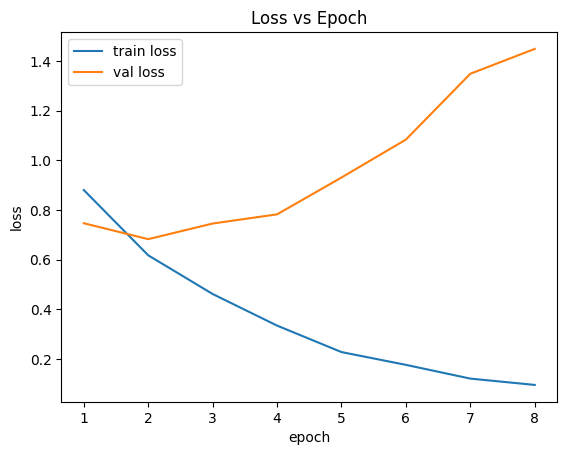

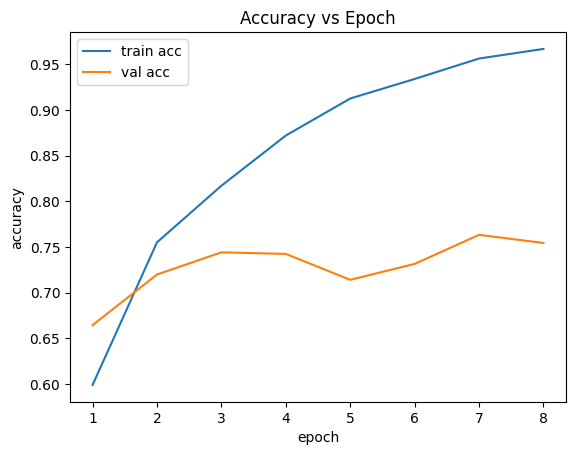

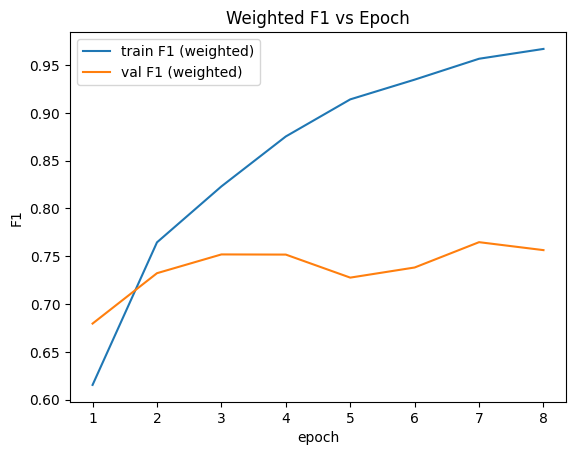

In [ ]:
EPOCHS = 15  # Max epochs (early stopping will control actual training)
history = []

# Early stopping setup
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, train=True)
    va_loss, va_acc, va_f1, y_true, y_pred = run_epoch(model, test_loader, train=False)

    history.append({
        "epoch": epoch,
        "train_loss": tr_loss,
        "val_loss": va_loss,
        "train_acc": tr_acc,
        "val_acc": va_acc,
        "train_f1_weighted": tr_f1,
        "val_f1_weighted": va_f1
    })

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1(w) {tr_f1:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} f1(w) {va_f1:.4f}", end="")
    
    # Early stopping check
    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_epoch = epoch
        patience_counter = 0
        print(" ✓ (best)")
    else:
        patience_counter += 1
        print(f" (patience: {patience_counter}/{patience})")
        
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}. Best epoch was {best_epoch} with val_loss={best_val_loss:.4f}")
        break

plt.show()

hist_df = pd.DataFrame(history)plt.xlabel("epoch"); plt.ylabel("F1"); plt.legend(); plt.title("Weighted F1 vs Epoch")

plt.plot(hist_df["epoch"], hist_df["val_f1_weighted"], label="val F1 (weighted)")

plt.figure()plt.plot(hist_df["epoch"], hist_df["train_f1_weighted"], label="train F1 (weighted)")

plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train loss")plt.figure()

plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val loss")

plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss vs Epoch")plt.show()

plt.show()plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy vs Epoch")

plt.plot(hist_df["epoch"], hist_df["val_acc"], label="val acc")

plt.figure()plt.plot(hist_df["epoch"], hist_df["train_acc"], label="train acc")

In [83]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(3)]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.83      0.85      1835
     neutral       0.56      0.57      0.56       620
    positive       0.63      0.69      0.66       473

    accuracy                           0.75      2928
   macro avg       0.68      0.70      0.69      2928
weighted avg       0.76      0.75      0.76      2928

Confusion Matrix:
 [[1528  206  101]
 [ 179  354   87]
 [  72   74  327]]


Confusion matrix saved to: confusion_matrices\confusion_matrix_bilstm.png


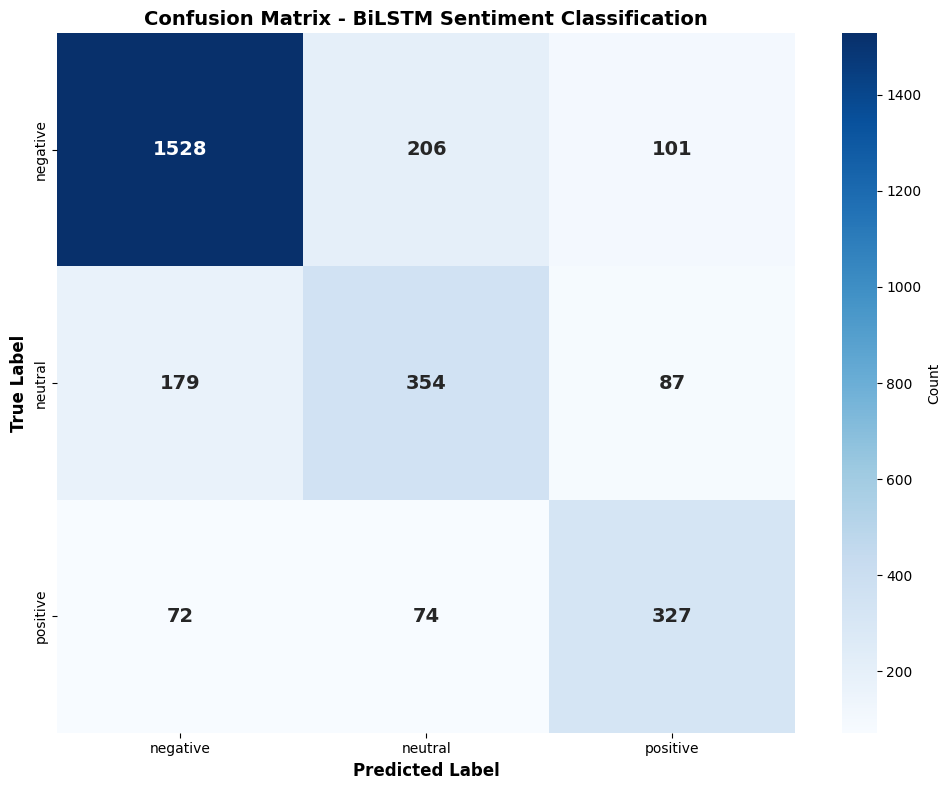

In [84]:
import seaborn as sns
import os

# Create confusion matrices directory if it doesn't exist
confusion_matrix_dir = "confusion_matrices"
os.makedirs(confusion_matrix_dir, exist_ok=True)

# Create a larger, more detailed confusion matrix visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=[id2label[i] for i in range(3)],
    yticklabels=[id2label[i] for i in range(3)],
    cbar_kws={'label': 'Count'},
    ax=ax,
    annot_kws={'size': 14, 'weight': 'bold'}
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - BiLSTM Sentiment Classification', fontsize=14, fontweight='bold')

plt.tight_layout()

# Save the confusion matrix
output_path = os.path.join(confusion_matrix_dir, "confusion_matrix_bilstm.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {output_path}")

plt.show()

In [85]:
@torch.no_grad()
def collect_misclassifications(model, texts, labels, max_show=10):
    model.eval()
    wrong = []

    class TweetDatasetWithIndex(Dataset):
        def __init__(self, texts, labels):
            self.texts = texts
            self.labels = labels
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            tokens = tokenize(self.texts[idx])
            ids = [word2idx.get(w, word2idx[UNK]) for w in tokens]
            x = torch.tensor(ids, dtype=torch.long)
            y = torch.tensor(self.labels[idx], dtype=torch.long)
            return x, y, idx

    def pad_pack_with_index(batch):
        xs, ys, idxs, lengths = [], [], [], []
        for x, y, idx in batch:
            xs.append(x); ys.append(y); idxs.append(idx); lengths.append(x.shape[0])
        lengths = torch.tensor(lengths, dtype=torch.long)
        ys = torch.stack(ys)
        x_padded = pad_sequence(xs, batch_first=False, padding_value=word2idx[PAD])
        x_packed = pack_padded_sequence(x_padded, lengths.cpu(), batch_first=False, enforce_sorted=False)
        return x_packed, ys, idxs

    ds_idx = TweetDatasetWithIndex(texts, labels)
    loader_idx = DataLoader(ds_idx, batch_size=64, shuffle=False, collate_fn=pad_pack_with_index)

    for x_packed, y, idxs in loader_idx:
        y = y.to(device)
        x_packed = x_packed.to(device)
        logits = model(x_packed)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        y_cpu = y.detach().cpu().numpy()

        for p, t, idx in zip(preds, y_cpu, idxs):
            if p != t:
                wrong.append((idx, t, p))
                if len(wrong) >= max_show:
                    return wrong
    return wrong

wrong_examples = collect_misclassifications(model, X_test, y_test, max_show=10)

print("\nMisclassifications (up to 10):")
for idx, true_id, pred_id in wrong_examples:
    print("-" * 80)
    print("TRUE:", id2label[true_id], "| PRED:", id2label[pred_id])
    print("TEXT:", X_test[idx])


Misclassifications (up to 10):
--------------------------------------------------------------------------------
TRUE: neutral | PRED: negative
TEXT: @united past
--------------------------------------------------------------------------------
TRUE: positive | PRED: negative
TEXT: @JetBlue would you say a delay is more likely? Thanks so much.
--------------------------------------------------------------------------------
TRUE: neutral | PRED: negative
TEXT: @united This link in your tweet goes to someone's internal email -&gt; http://t.co/ZksX79itdN...... Probably one of your 3rd party IT contracts
--------------------------------------------------------------------------------
TRUE: negative | PRED: positive
TEXT: @SouthwestAir BETSY is the BESTY! Gettin' stuck at #LAS might not be bad for most..but I want home! #homewardbound #betsy #besty #thankyou
--------------------------------------------------------------------------------
TRUE: negative | PRED: neutral
TEXT: @SouthwestAir Whe

{'embed_dim': 128, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.002} -> best val F1(w): 0.7691006491509026
{'embed_dim': 128, 'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.002} -> best val F1(w): 0.7588546847534612
{'embed_dim': 128, 'hidden_dim': 384, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001} -> best val F1(w): 0.7420111404005026
{'embed_dim': 256, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.4, 'lr': 0.001} -> best val F1(w): 0.764559443771353

Tuning Results (sorted by best val F1 weighted):


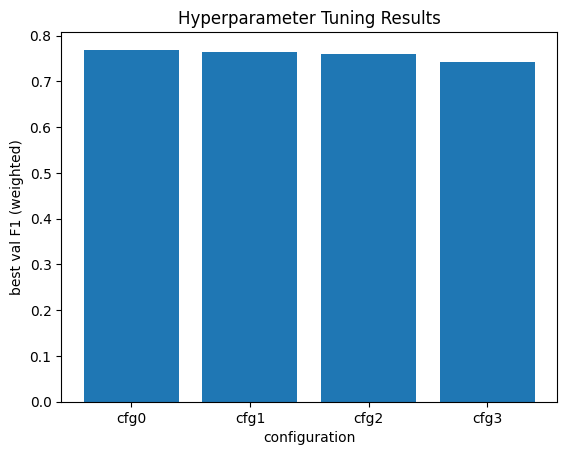


Config mapping:
cfg0: embed=128, hidden=256, layers=2, dropout=0.3, lr=0.002
cfg1: embed=256, hidden=256, layers=2, dropout=0.4, lr=0.001
cfg2: embed=128, hidden=256, layers=1, dropout=0.2, lr=0.002
cfg3: embed=128, hidden=384, layers=2, dropout=0.3, lr=0.001


In [68]:
def train_one_config(embed_dim, hidden_dim, num_layers, dropout, lr, epochs=6):
    m = BiLSTMSentiment(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        num_classes=3,
        pad_idx=word2idx[PAD]
    ).to(device)

    local_opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=1e-2)

    best_val_f1 = -1.0
    best_val_acc = -1.0
    best_val_loss = 1e9

    for _ in range(epochs):
        # train
        m.train()
        for x_packed, y, lengths in train_loader:
            y = y.to(device)
            x_packed = x_packed.to(device)
            local_opt.zero_grad()
            logits = m(x_packed)
            loss = loss_fn(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(m.parameters(), max_norm=1.0)
            local_opt.step()

        # validate
        val_loss, val_acc, val_f1, _, _ = run_epoch_eval_only(m, test_loader)
        best_val_f1 = max(best_val_f1, val_f1)
        best_val_acc = max(best_val_acc, val_acc)
        best_val_loss = min(best_val_loss, val_loss)

    return best_val_loss, best_val_acc, best_val_f1

search_space = [
    {"embed_dim": 128, "hidden_dim": 256, "num_layers": 2, "dropout": 0.3, "lr": 2e-3},
    {"embed_dim": 128, "hidden_dim": 256, "num_layers": 1, "dropout": 0.2, "lr": 2e-3},
    {"embed_dim": 128, "hidden_dim": 384, "num_layers": 2, "dropout": 0.3, "lr": 1e-3},
    {"embed_dim": 256, "hidden_dim": 256, "num_layers": 2, "dropout": 0.4, "lr": 1e-3},
]

results = []
for cfg in search_space:
    val_loss, val_acc, val_f1 = train_one_config(**cfg, epochs=6)
    results.append({
        **cfg,
        "best_val_loss": val_loss,
        "best_val_acc": val_acc,
        "best_val_f1_weighted": val_f1
    })
    print(cfg, "-> best val F1(w):", val_f1)

tune_df = pd.DataFrame(results).sort_values("best_val_f1_weighted", ascending=False)
print("\nTuning Results (sorted by best val F1 weighted):")
tune_df

plt.figure()
plt.bar(range(len(tune_df)), tune_df["best_val_f1_weighted"].values)
plt.xticks(range(len(tune_df)), [f"cfg{i}" for i in range(len(tune_df))], rotation=0)
plt.xlabel("configuration")
plt.ylabel("best val F1 (weighted)")
plt.title("Hyperparameter Tuning Results")
plt.show()

print("\nConfig mapping:")
for i, row in tune_df.reset_index(drop=True).iterrows():
    print(f"cfg{i}: embed={int(row.embed_dim)}, hidden={int(row.hidden_dim)}, layers={int(row.num_layers)}, "
          f"dropout={row.dropout}, lr={row.lr}")